In [1]:
#import libraries
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.patches as mpatches
style.use('ggplot')

In [9]:
top_10_performers_df = pd.DataFrame(columns=["Year","title"])

In [49]:
# initialize list of years to process
yrs_to_process=[1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,
                 2014,2015,2016,2017]

#list to hold marvel monthly count for a year
# marvel_mntly_top_thirty = []
#list to hold DC monthly count for a year
# dc_mntly_top_ten = []

#attributes /column names needed to plot charts
publishers_attributes = ["Marvel_Top_Thirty","DC_Top_Thirty",'Others_Top_Thirty','Marvel_Total_Sold',
                         'DC_Total_Sold','Total_Sold']

#create publishers stats dataframe with years as the index and attributes as columns
publishers_stats_df = pd.DataFrame(index=yrs_to_process ,columns=publishers_attributes)
# df_publishers_total_sold = pd.DataFrame(index=yrs_to_process ,columns="Marvel","DC",'Others')
#initialize all columns to zero
publishers_stats_df = publishers_stats_df.fillna(value=0)

top_10_performers_df = pd.DataFrame(columns=["Year", "title",'fileName'])


# through all years initialized in dataframe
for index,row in publishers_stats_df.iterrows():
    #list to hold marvel monthly count for a year
    #reset marvel and DC monthly top 10 stats list when processing every year
    marvel_mntly_top_thirty = []
    dc_mntly_top_thirty = []
    
    #process each monthly json file for the year being processed
    for comichron_json in glob.glob("./source-data/" + str(index) + "-*.json"):
        if os.path.isfile(comichron_json):
            print(f"Processing file {comichron_json}")
            #read json file
            monthly_df = pd.read_json(comichron_json)
            
            monthly_df["Year"] = index
            monthly_df["fileName"] = comichron_json
            
            #sum monthly count of comic books sold and add it to running total in publishers stats dataframe
            row['Total_Sold'] = row['Total_Sold'] + monthly_df["count"].sum()
            #sum monthly count of comic books for Marvel sold and add it to running total in publishers stats dataframe
            row['Marvel_Total_Sold'] += monthly_df[monthly_df["publisher"] == 'Marvel']["count"].sum()
            #sum monthly count of comic books for DC sold and add it to running total in publishers stats dataframe
            row['DC_Total_Sold'] += monthly_df[monthly_df["publisher"] == 'DC']["count"].sum()
            
            #sort and get top thirty comics sold
            monthly_top_30 = monthly_df.sort_values(by = "count" ,ascending=False ).head(30)
            #count how many times marvel occur in top 30
            marvel_mntly_top_thirty.append(len(monthly_top_30[monthly_top_30["publisher"] == 'Marvel']))
            #count how many times DC occur in top 30
            dc_mntly_top_thirty.append(len(monthly_top_30[monthly_top_30["publisher"] == 'DC']))
            
            monthly_top_10 = monthly_df.sort_values(by = "count" ,ascending=False ).head(10)
#             monthly_top_10 = monthly_top_10.reset_index()
            
            top_10_performers_df = top_10_performers_df.append(monthly_top_10[["title", "Year","fileName"]])
            
            
    
    #calculate average for the year
    row["Marvel_Top_Thirty"] = np.mean(marvel_mntly_top_thirty)
    row["DC_Top_Thirty"] = np.mean(dc_mntly_top_thirty)
    row["Others_Top_Thirty"] = 30 - (row["Marvel_Top_Thirty"] + row["DC_Top_Thirty"])
            


Processing file ./source-data/1997-03.json
Processing file ./source-data/1997-02.json
Processing file ./source-data/1997-05.json
Processing file ./source-data/1997-09.json
Processing file ./source-data/1997-08.json
Processing file ./source-data/1997-12.json
Processing file ./source-data/1997-04.json
Processing file ./source-data/1997-11.json
Processing file ./source-data/1997-07.json
Processing file ./source-data/1997-06.json
Processing file ./source-data/1997-10.json
Processing file ./source-data/1997-01.json
Processing file ./source-data/1998-06.json
Processing file ./source-data/1998-10.json
Processing file ./source-data/1998-11.json
Processing file ./source-data/1998-07.json
Processing file ./source-data/1998-01.json
Processing file ./source-data/1998-02.json
Processing file ./source-data/1998-03.json
Processing file ./source-data/1998-12.json
Processing file ./source-data/1998-04.json
Processing file ./source-data/1998-08.json
Processing file ./source-data/1998-09.json
Processing 

Processing file ./source-data/2013-11.json
Processing file ./source-data/2013-07.json
Processing file ./source-data/2013-01.json
Processing file ./source-data/2014-10.json
Processing file ./source-data/2014-06.json
Processing file ./source-data/2014-07.json
Processing file ./source-data/2014-11.json
Processing file ./source-data/2014-01.json
Processing file ./source-data/2014-02.json
Processing file ./source-data/2014-03.json
Processing file ./source-data/2014-08.json
Processing file ./source-data/2014-04.json
Processing file ./source-data/2014-12.json
Processing file ./source-data/2014-05.json
Processing file ./source-data/2014-09.json
Processing file ./source-data/2015-07.json
Processing file ./source-data/2015-11.json
Processing file ./source-data/2015-10.json
Processing file ./source-data/2015-06.json
Processing file ./source-data/2015-01.json
Processing file ./source-data/2015-03.json
Processing file ./source-data/2015-02.json
Processing file ./source-data/2015-09.json
Processing 

In [54]:
# top_10_performers_df[top_10_performers_df["Year"]== 2016 & top_10_performers_df["title"]]
top_10_performers_df["test"] = top_10_performers_df['title'].str.contains('Daredevil')
# test.value_counts()
top_10_performers_df[top_10_performers_df["test"] == True]

,Year,fileName,title,test
9,1998,./source-data/1998-09.json,Daredevil,True
7,1999,./source-data/1999-11.json,Daredevil,True
9,1999,./source-data/1999-07.json,Daredevil,True
8,1999,./source-data/1999-06.json,Daredevil,True
7,1999,./source-data/1999-10.json,Daredevil,True
9,1999,./source-data/1999-03.json,Daredevil,True
9,1999,./source-data/1999-02.json,Daredevil,True
6,1999,./source-data/1999-09.json,Daredevil,True
7,1999,./source-data/1999-08.json,Daredevil,True
7,1999,./source-data/1999-12.json,Daredevil,True


In [3]:
#name index to year ,reset index and display calculated stats
dfs = np.split(publishers_stats_df, [3], axis=1)
top_30_publishers_stats_df = dfs[0]
top_30_publishers_stats_df = top_30_publishers_stats_df.reset_index()
top_30_publishers_stats_df = top_30_publishers_stats_df.rename(columns={'index': 'Year', 
                                                                        'Marvel_Top_Thirty': 'Marvel',
                                                                        'DC_Top_Thirty': 'DC',
                                                                        'Others_Top_Thirty': 'Others'  })
total_sold_publishers_stats_df = dfs[1]
total_sold_publishers_stats_df = total_sold_publishers_stats_df.reset_index()
total_sold_publishers_stats_df = total_sold_publishers_stats_df.rename(columns={'index': 'Year', 
                                                                        'Marvel_Total_Sold': 'Marvel',
                                                                        'DC_Total_Sold': 'DC',
                                                                        'Total_Sold': 'Total'  })



In [4]:
top_30_publishers_stats_df


,Year,Marvel,DC,Others
0,1997,18,4,8
1,1998,18,4,8
2,1999,19,6,5
3,2000,19,6,5
4,2001,20,6,4
5,2002,20,6,4
6,2003,21,5,4
7,2004,21,8,1
8,2005,19,10,1
9,2006,17,12,1


In [5]:
total_sold_publishers_stats_df

,Year,Marvel,DC,Total
0,1997,34985441,28097651,96154708
1,1998,28811621,24753072,81370613
2,1999,25793551,25802128,73533305
3,2000,22457597,23905108,66331411
4,2001,26143410,21102509,64312599
5,2002,31473401,20685102,70837161
6,2003,31323386,22750790,71139392
7,2004,35234972,25379713,72733899
8,2005,34821847,28910833,74008729
9,2006,36328753,32188030,78872675


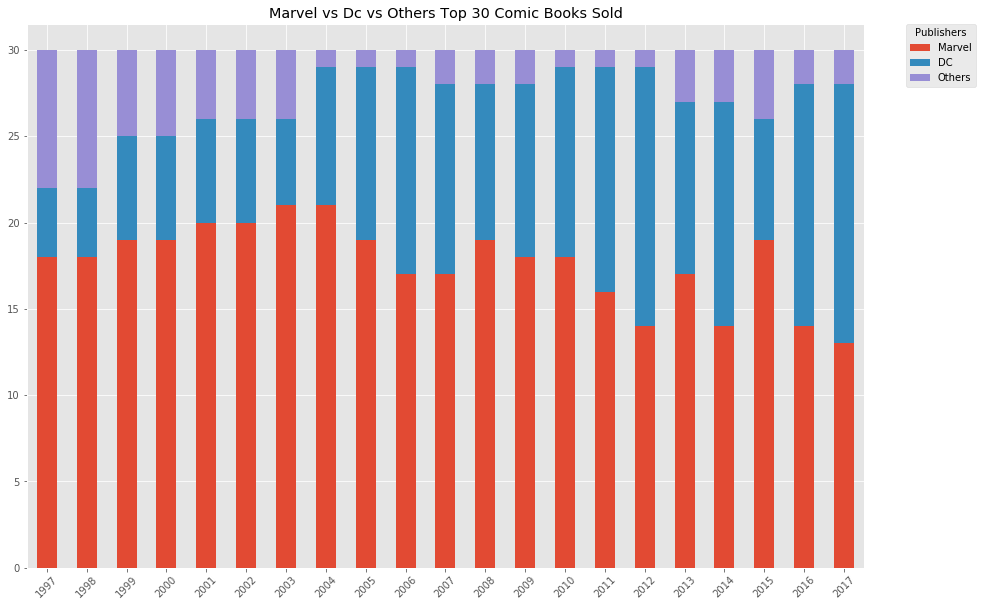

In [6]:
ax = top_30_publishers_stats_df[["Marvel","DC","Others"]]\
                        .plot(kind='bar',figsize=(15, 10),stacked = True,\
                         title="Marvel vs Dc vs Others Top 30 Comic Books Sold")
ax.set_xticklabels(yrs_to_process,rotation=45)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,title="Publishers")
plt.show()

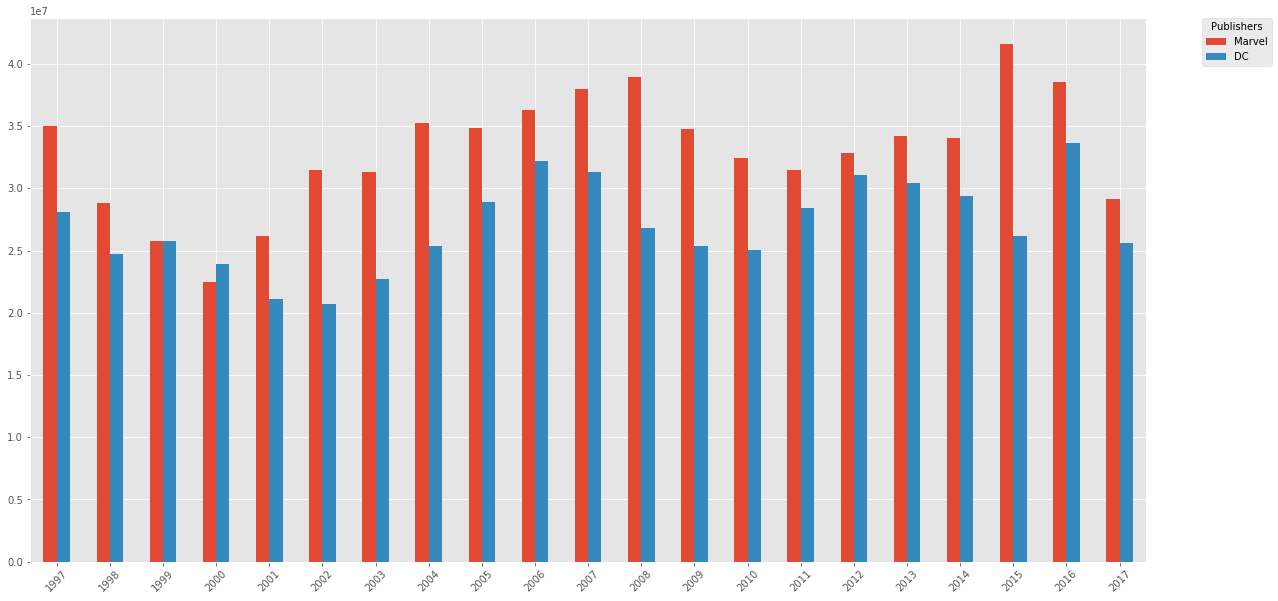

In [7]:

ax = total_sold_publishers_stats_df[["Marvel","DC"]].plot(kind='bar',figsize=(20, 10))
ax.set_xticklabels(yrs_to_process,rotation=45)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,title="Publishers")
plt.show()


# Set x and y limits
# plt.xlim(-0.25, len(x_axis))
# plt.ylim(0, max(rain_df["Inches"])+10)
# plt.title("Average Rain per State")
# plt.xlabel("State")
# plt.ylabel("Average Amount of Rainfall in Inches")